In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

%run insights.py
%run plot.py

In [2]:
spark = SparkSession.builder.getOrCreate()

In [275]:
# Load all datasets
metrics = spark.read.load('../data/dataset_metrics.parquet').toPandas()
score_metrics = spark.read.load('../data/score_metrics.parquet').toPandas().set_index('score')
comments = spark.read.load('../data/sample.parquet')
comments.registerTempTable("comments")
daily_metrics = spark.read.load('../data/daily_metrics.parquet').toPandas().set_index('created')
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
daily_agreement = spark.read.load('../data/daily_agreement.parquet').toPandas().set_index('created')
lda_result_one_w_df = spark.read.load('../data/oneW_oneT_lda_result.parquet').toPandas().set_index('post_id')
lda_result_three_w_df = spark.read.load('../data/threeW_twoT_lda_result.parquet').toPandas().set_index('post_id')
nlp = spark.read.load('../data/subreddit_nlp_full_0.001.parquet')
nlp.registerTempTable("nlp")
nlp_per_community = spark.read.load('../data/nlp_per_community.parquet')
agreement_per_community = spark.read.load('../data/agreement_per_community.parquet').toPandas().set_index('Group')

In [ ]:
def fetch_metric_for_group(metric, group):    
    return spark.sql("""
        SELECT {}
        FROM nlp JOIN subreddits ON LOWER(nlp.subreddit) == subreddits.subreddit
        WHERE subreddits.Group == '{}'
    """.format(metric, group)).toPandas()

In [4]:
def load_subreddit_list(name, subgroup=None):

    with open('../data/subreddits/' + name + '.txt') as f:
        lines = f.readlines()

    group = ""
    subreddit_list_df = pd.DataFrame(data=[], columns=['type'])

    for line in lines:

        if line == '\n':
            continue

        if line[0] == '#':
            group = line[2:].strip('\n')
            continue
            
        if subgroup != None and group not in subgroup:
            continue

        subreddit = line[3:].strip('\n').lower()

        subreddit_list_df.loc[subreddit] = group
    
    return subreddit_list_df


### A Look at Reddit Communities

Now that we have a pretty good idea of how we can measure divisiveness, negativity and vulgarity, it is interesting to take a deeper dive into specific sub-communities and see how these metrics compare. 

In order to do that, we initially compiled a list of communities related to a specific topic. This was done with the help of [/r/ListOfSubreddits](https://www.reddit.com/r/ListOfSubreddits/wiki/listofsubreddits) which provides an extensive list of active communities organized by topic. First of all, we decided to extract 4 macro communities. 

* **Politics**, which contains all subreddits linked to discussions about politics, political ideologies, political news, political candidates and so forth.
* **Sports**, another big group of commmunities linked to discussions on sports in general, a specific sport or a specific sports team.
* **Music**,
* **Video Games**

### Negativity & Positivity | High Level

First, we will analyze how the negativity and positivity metrics we computed earlier vary depending on the macro-communities chosen.

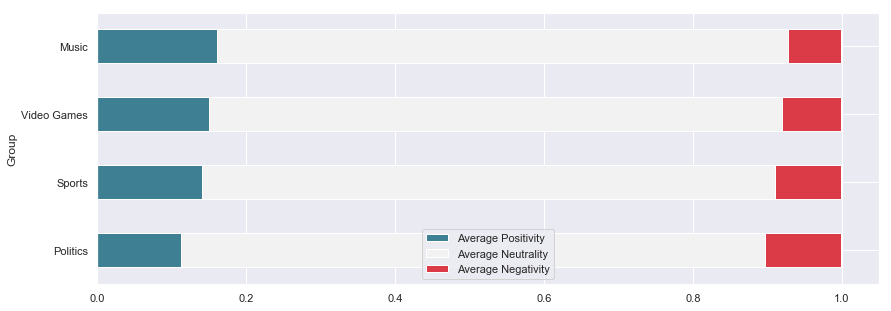

In [139]:
# Using Spark, get the mean positivity, negativity, neutrality, etc... for each "Group" (= macro-community)
nlp_per_community_group_avg_df = nlp_per_community.groupBy(func.col('Group')).mean().toPandas().set_index('Group').rename(columns={
    'avg(Negativity)': 'Average Negativity', 
    'avg(Positivity)': 'Average Positivity', 
    'avg(Neutrality)': 'Average Neutrality',
    'avg(Vulgarity)': 'Average Vulgarity'
})

# Plot the neutrality, positivity and negativity of each Group
_ = nlp_per_community_group_avg_df[['Average Positivity', 'Average Neutrality','Average Negativity']].sort_values('Average Positivity').plot(
    kind='barh', 
    stacked=True, 
    colormap=ListedColormap(sns.diverging_palette(220, 10, sep=80, n=3)), 
    figsize=(14,5)
)

From the chart above, we can see that, even though most of the discussion is neutral, Politics is simultaneously the most negative and least positive type of discussion. Let's look at it this by also looking

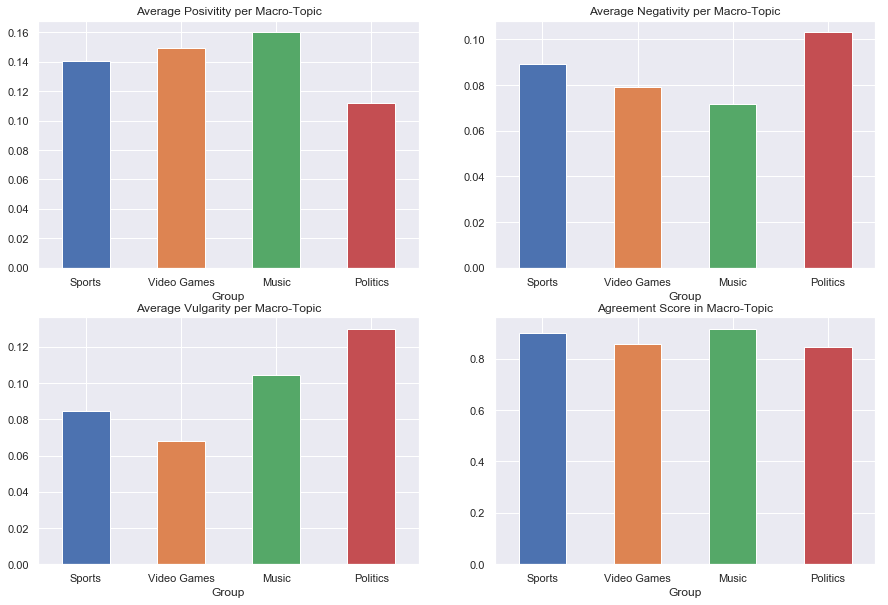

In [274]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0, 0].set_title("Average Posivitity per Macro-Topic")
axes[0, 1].set_title("Average Negativity per Macro-Topic")
axes[1, 0].set_title("Average Vulgarity per Macro-Topic")
axes[1, 1].set_title("Agreement Score in Macro-Topic")

_ = nlp_per_community_group_avg_df['Average Positivity'].plot(
    kind='bar', ax=axes[0, 0], rot=0
)

_ = nlp_per_community_group_avg_df['Average Negativity'].plot(
    kind='bar', ax=axes[0, 1], rot=0
)

_ = nlp_per_community_group_avg_df['Average Vulgarity'].plot(
    kind='bar', ax=axes[1, 0], rot=0
)

_ = agreement_per_community['agreement_factor'].reindex(nlp_per_community_group_avg_df.index).plot(
    kind='bar', ax=axes[1, 1], rot=0
)

TEXT

In [196]:
# Fetch all comments and their negativity for each subgroup, store it because it is expensive
politics_negativity = fetch_metric_for_group('nltk_negativity', 'Politics'),
sports_negativity = fetch_metric_for_group('nltk_negativity', 'Sports'),
music_negativity = fetch_metric_for_group('nltk_negativity', 'Music'),
videogames_negativity = fetch_metric_for_group('nltk_negativity', 'Video Games')

In [197]:
# Same for positivity
politics_positivity = fetch_metric_for_group('nltk_positivity', 'Politics'),
sports_positivity = fetch_metric_for_group('nltk_positivity', 'Sports'),
music_positivity = fetch_metric_for_group('nltk_positivity', 'Music'),
videogames_positivity = fetch_metric_for_group('nltk_positivity', 'Video Games')

In [277]:
# Same for vulgarity
politics_vulgarity = fetch_metric_for_group('nb_bw_matches', 'Politics'),
sports_vulgarity = fetch_metric_for_group('nb_bw_matches', 'Sports'),
music_vulgarity = fetch_metric_for_group('nb_bw_matches', 'Music'),
videogames_vulgarity = fetch_metric_for_group('nb_bw_matches', 'Video Games')

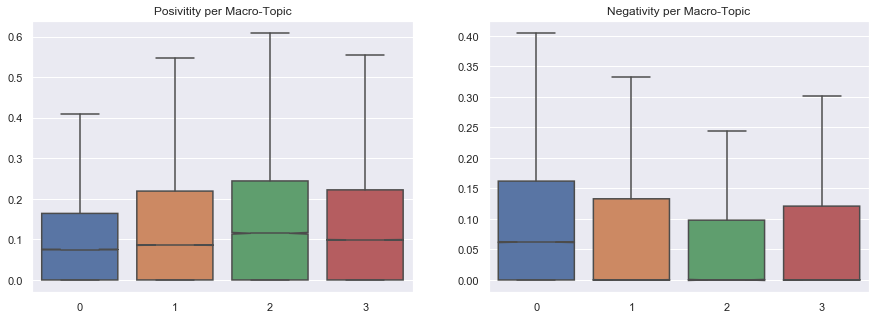

In [279]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("Posivitity per Macro-Topic")
axes[1].set_title("Negativity per Macro-Topic")

sns.boxplot(data=[
    politics_positivity[0],
    sports_positivity[0],
    music_positivity[0],
    videogames_positivity
], ax=axes[0], showfliers=False, notch=True)

_ = sns.boxplot(data=[
    politics_negativity[0],
    sports_negativity[0],
    music_negativity[0],
    videogames_negativity
], ax=axes[1], showfliers=False, notch=True)

In [8]:
group_metrics = filtered_nlp_df.groupby('Group').agg('mean')
group_metrics['count'] = filtered_nlp_df.groupby('Group').count()['id']

group_metrics = group_metrics.rename(columns={
    'nltk_negativity': 'Negativity',
    'nltk_positivity': 'Positivity',
    'nltk_neutrality': 'Neutrality',
    'nb_bw_matches': 'Vulgarity',
    'count': 'Count'
})

In [ ]:
nlp_per_community.groupby('Group').agg('mean')['Negativity'].plot(kind='barh')

In [18]:
import seaborn as sns

# sns.barplot(group_metrics.index, group_metrics['Neutrality'], palette='Reds')
from matplotlib.colors import ListedColormap

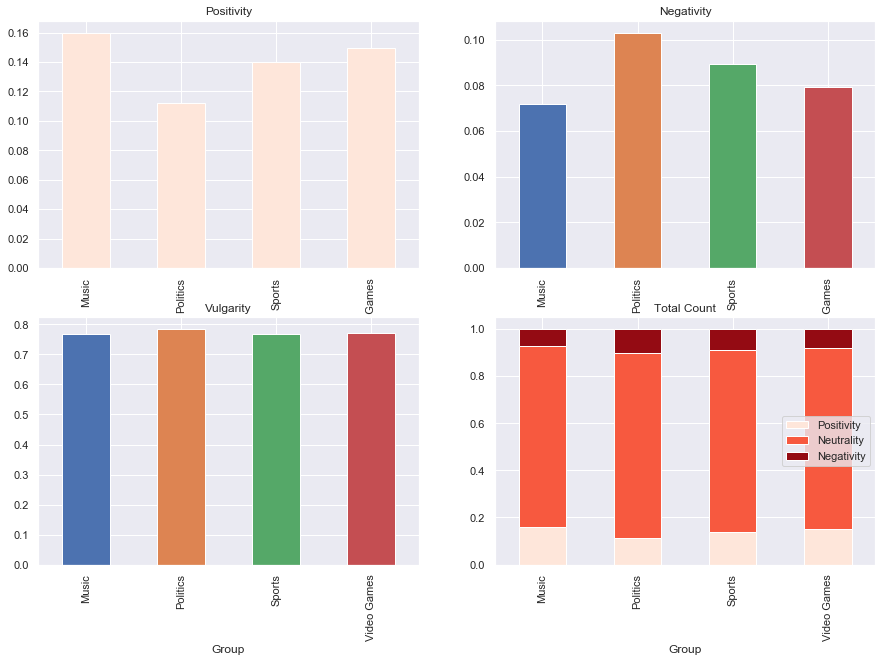

In [28]:
# sns.set()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

group_metrics['Positivity'].plot(kind='bar', ax=axes[0,0], colormap=ListedColormap(sns.color_palette("Reds", 10)))
group_metrics['Negativity'].plot.bar(ax=axes[0,1])
group_metrics['Neutrality'].plot.bar(ax=axes[1,0])
# group_metrics['Count'].plot.bar(ax=axes[1,1])

axes[0,0].set_title("Positivity")
axes[0,1].set_title("Negativity")
axes[1,0].set_title("Vulgarity")
_ = axes[1,1].set_title("Total Count")

We can see here that Politics seems to be the most negative out of all of the topics chosen.

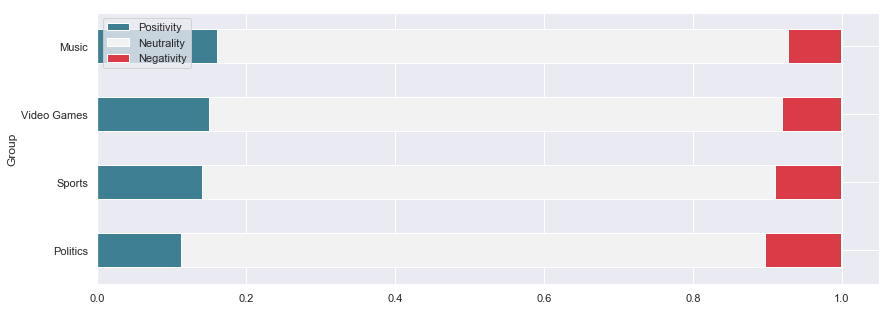

In [97]:
from numpy import median
group_metrics[['Positivity', 'Neutrality','Negativity']]

In [115]:
nlp_per_group_df = nlp_per_community.groupby(func.col('Group')).agg('mean')

KeyboardInterrupt: 

,Negativity,Positivity,Neutrality,Vulgarity
Group,,,,
Sports,0.089352,0.140203,0.769546,0.084548
Video Games,0.079255,0.149531,0.770203,0.068149
Music,0.071611,0.159956,0.767676,0.104271
Politics,0.103010,0.112316,0.784091,0.129858


In [33]:
nlp.filter(nlp.subreddit.isin(list(political_subreddits.index))).agg({"nltk_negativity": "avg"}).show()

+--------------------+
|avg(nltk_negativity)|
+--------------------+
| 0.10786359365555655|
+--------------------+



In [35]:
nlp.filter(nlp.subreddit.isin(list(political_subreddits.index))).count()

69007

In [36]:
nlp.count()

2876334

,nltk_negativity,Positivity,Neutrality,Vulgarity,Count
Group,,,,,
Music,0.071611,0.159956,0.767676,0.104271,34257
Politics,0.103010,0.112316,0.784091,0.129858,111368
Sports,0.089352,0.140203,0.769546,0.084548,198112
Video Games,0.079255,0.149531,0.770203,0.068149,429310


In [72]:
filtered_nlp_df.shape

(488031, 7)

In [74]:
filtered_nlp_df.shape

(773047, 7)

In [59]:
political_nlp_df

,id,subreddit,subreddit_id,creation_date,body,nltk_negativity,nltk_neutrality,nltk_positivity,text_blob_polarity,text_blob_subjectivity,nb_bw_matches,nb_hw_matches,hw_ref_intensity,nb_hw_ref_matches
0,d5qjwx8,news,t5_2qh3l,2016-07-25,"Before I click, it's New Jersey, isn't it. \n\...",0.149,0.730,0.122,0.00,0.0,0,0,NaN,0.0
1,d5qke83,news,t5_2qh3l,2016-07-25,You can't pull a gun to keep from getting beat...,0.102,0.808,0.091,0.00,0.0,1,0,NaN,0.0
3,d60phdw,news,t5_2qh3l,2016-08-02,I would assume since you're a university profe...,0.091,0.909,0.000,0.00,0.0,0,0,NaN,0.0
4,d60q5p1,news,t5_2qh3l,2016-08-02,Sorry. I mean that were talking about the leas...,0.072,0.720,0.208,0.00,0.0,0,0,NaN,0.0
5,d60qaqn,worldnews,t5_2qh13,2016-08-02,How disingenuous. In Europe if you get caught ...,0.135,0.813,0.052,0.00,0.0,3,0,NaN,0.0
6,d60qh05,news,t5_2qh3l,2016-08-02,I bet the average GPA goes up and a lot fewer ...,0.143,0.857,0.000,0.00,0.0,0,0,NaN,0.0
7,d60s68j,ukpolitics,t5_2qhcv,2016-08-02,Labour have one seat in Scotland. Unless the S...,0.000,0.921,0.079,0.00,0.0,0,0,NaN,0.0
8,c5981d2,worldpolitics,t5_2qh9a,2012-07-04,So you steal from the poor family next door 'c...,0.124,0.849,0.027,0.00,0.0,0,0,NaN,0.0
9,c598xoq,worldnews,t5_2qh13,2012-07-04,Tuticorin :Sterlite Copper in association with...,0.000,0.899,0.101,0.00,0.0,0,0,NaN,0.0
10,c599sfv,conspiratard,t5_2r2dd,2012-07-04,so apparently words can mean anything now? you...,0.129,0.800,0.070,0.00,0.0,1,0,NaN,0.0


In [68]:
political_nlp_df = nlp.filter(func.col('subreddit').isin(list(political_subreddits.index))).toPandas()
sports_nlp_df = nlp.filter(func.col('subreddit').isin(list(sports_subreddits.index))).toPandas()
music_nlp_df = nlp.filter(func.col('subreddit').isin(list(music_subreddits.index))).toPandas()
videogames_nlp_df = nlp.filter(func.col('subreddit').isin(list(videogames_subreddits.index))).toPandas()

In [92]:
sports_nlp_df['nltk_negativity'].median()

0.0

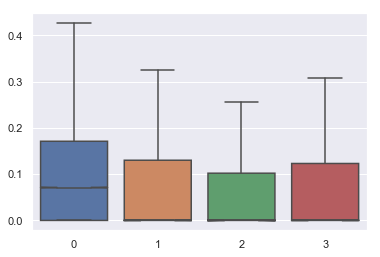

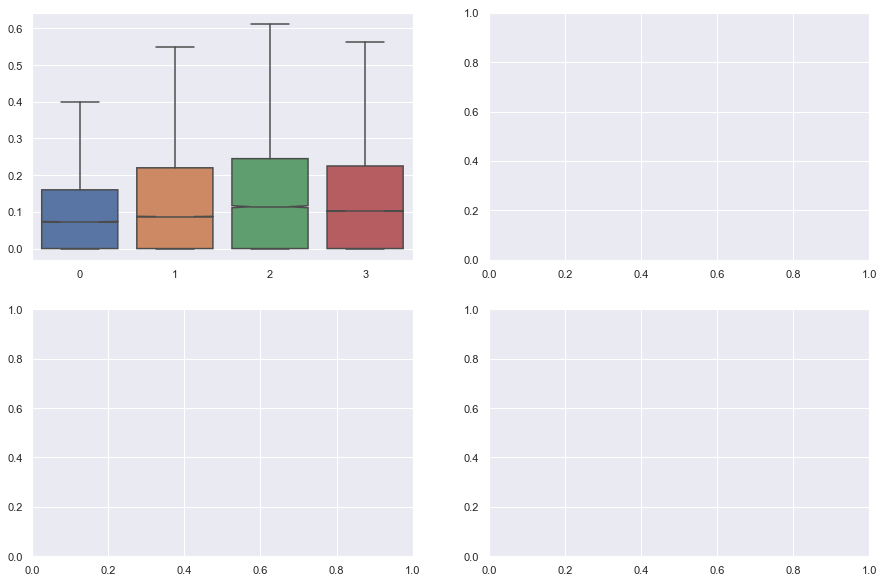

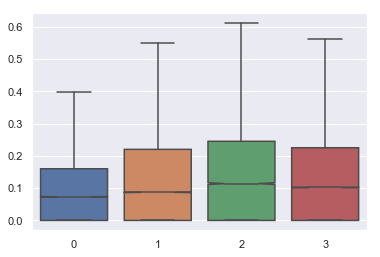

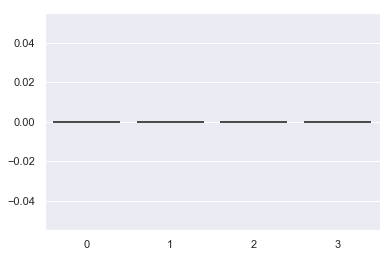

In [85]:
sns.boxplot(data=[
    political_nlp_df['nb_bw_matches'], 
    sports_nlp_df['nb_bw_matches'],
    music_nlp_df['nb_bw_matches'],
    videogames_nlp_df['nb_bw_matches'],
], showfliers=False, notch=True)

In [99]:
sns.violinplot(data=political_nlp_df[political_nlp_df['body'].str.len() > 10]['nltk_negativity'], inner="points")

In [113]:
spark.sql("""
SELECT 
    id, 
    creation_date, 
    body, 
    nltk_negativity AS Negativity, 
    nltk_positivity AS Positivity,
    nltk_neutrality AS Neutrality,
    nb_bw_matches AS Vulgarity,
    nlp.subreddit, 
    subreddits.Group, 
    subreddits.Subgroup
FROM nlp JOIN subreddits ON LOWER(nlp.subreddit) == subreddits.subreddit
""").write.mode('overwrite').parquet('nlp_per_community.parquet')

In [124]:
politics_group_metrics = politics_filtered_nlp_df.groupby('Subgroup').agg('mean')
politics_group_metrics['count'] = politics_filtered_nlp_df.groupby('Subgroup').count()['id']

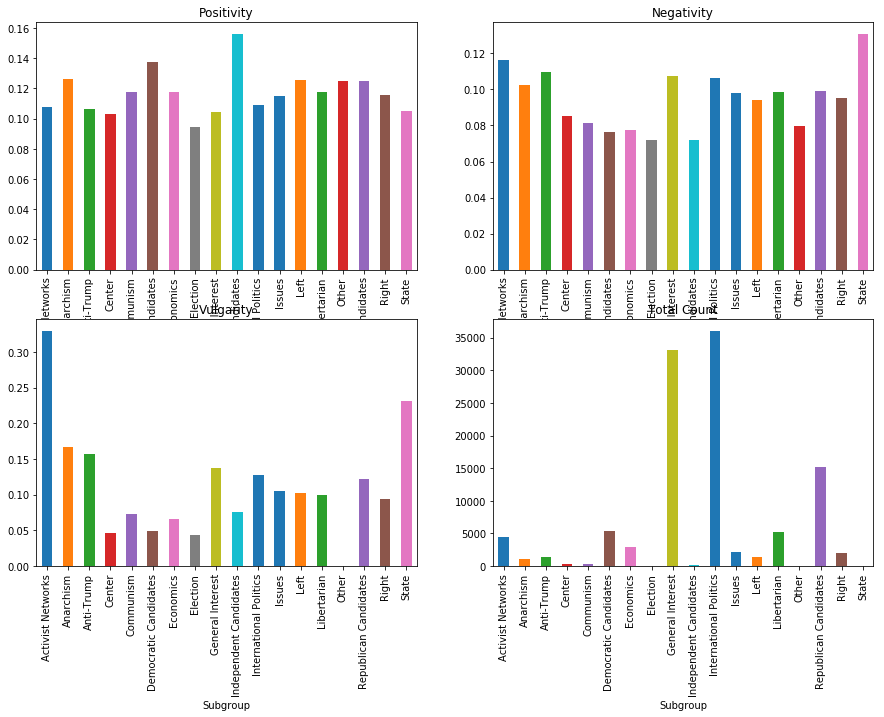

In [125]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

politics_group_metrics['nltk_positivity'].plot.bar(ax=axes[0,0])
politics_group_metrics['nltk_negativity'].plot.bar(ax=axes[0,1])
politics_group_metrics['nb_bw_matches'].plot.bar(ax=axes[1,0])
politics_group_metrics['count'].plot.bar(ax=axes[1,1])

axes[0,0].set_title("Positivity")
axes[0,1].set_title("Negativity")
axes[1,0].set_title("Vulgarity")
_ = axes[1,1].set_title("Total Count")

In [143]:
politics_subreddit_metrics = politics_filtered_nlp_df.groupby('subreddit').agg('mean')
politics_subreddit_metrics['count'] = politics_filtered_nlp_df.groupby('subreddit').count()['id']

In [148]:
politics_subreddit_metrics[politics_subreddit_metrics['count'] > 10].sort_values('nltk_negativity', ascending=False)

,nltk_negativity,nltk_positivity,nltk_neutrality,nb_bw_matches,count
subreddit,,,,,
DescentIntoTyranny,0.146429,0.083071,0.770429,0.214286,14
Bad_Cop_No_Donut,0.144972,0.097063,0.757981,0.188047,686
new_right,0.144000,0.119556,0.736444,0.000000,18
AmericanPolitics,0.137133,0.091033,0.771800,0.066667,30
MarchAgainstTrump,0.136835,0.144412,0.718682,0.152941,85
LibertarianLeft,0.125125,0.089813,0.785062,0.062500,16
GunsAreCool,0.124852,0.112657,0.762485,0.142012,169
Trumpgret,0.124634,0.127317,0.748000,0.170732,41
gunpolitics,0.124288,0.096542,0.779158,0.163842,177


In [134]:
a = spark.sql("""
SELECT score, body, subreddit
FROM comments
ORDER BY score DESC
LIMIT 20
""").toPandas()

In [136]:
a.loc[0].body

"I don't want to give too much details because this story is quite specific and potentially humiliating for the person we didn't hire. \n\nWe interviewed a young guy for a position, and I did the basic check with his former employers once they were shortlisted for the final interviews. All came in fine except one... where they asked to have a phone conversation about the candidate. I got a call from them wherein they explained that he'd actually been fired for repeatedly posting photos to the company instagram and twitter which contained hidden 'items' that weren't meant to be in there. I pushed and pushed to find out exactly what they meant, and it turns out this person we were interviewing to manager our social media had been posting photos with his genitals hidden in the photos for months before his bosses had noticed. \n\n"

In [141]:
b = spark.sql("""
SELECT score, body, subreddit, author
FROM comments
ORDER BY score
LIMIT 20
""").toPandas()

In [142]:
b.loc[0]

score                                                     -654
body         Ah, shoot. Almost had it all! Just thought I'd...
subreddit                                           casualiama
author                                               [deleted]
Name: 0, dtype: object

In [149]:
political_issues_subreddits = load_subreddit_list('political_issues_subreddits')

In [158]:
nlp_df = nlp.filter(nlp.subreddit.isin(list(political_issues_subreddits.index))).toPandas()

In [ ]:
nlp_df[nlp_df['subreddit'].isin(political_issues_subreddits.index)]

In [162]:
h = nlp_df.groupby('subreddit').mean()

In [168]:
h.loc[:, 'count'] = nlp_df.groupby('subreddit').count()['id']

In [173]:
h[h['count'] > 10].sort_values('nltk_negativity')

,nltk_negativity,nltk_neutrality,nltk_positivity,text_blob_polarity,text_blob_subjectivity,nb_bw_matches,nb_hw_matches,hw_ref_intensity,nb_hw_ref_matches,count
subreddit,,,,,,,,,,
labor,0.027091,0.865909,0.106909,0.000000,0.000000,0.090909,0.000000,NaN,0.000000,11
timetolegalize,0.050050,0.776850,0.173000,0.000000,0.000000,0.050000,0.100000,NaN,0.000000,20
privacy,0.070058,0.808916,0.121031,0.007743,0.030973,0.088496,0.008850,NaN,0.000000,226
trees,0.072425,0.763822,0.163091,0.016556,0.056540,0.113080,0.016387,0.7053,0.001391,16537
restorethefourth,0.078033,0.760650,0.161333,0.000000,0.000000,0.166667,0.016667,NaN,0.000000,60
climateskeptics,0.087391,0.803641,0.108940,0.008492,0.032609,0.092391,0.043478,NaN,0.000000,184
prochoice,0.097714,0.806143,0.095929,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,14
environment,0.097835,0.793774,0.106661,0.003038,0.017361,0.076389,0.031250,0.6670,0.001736,576
climate,0.110436,0.774600,0.115000,-0.013636,0.018182,0.018182,0.000000,NaN,0.000000,55


In [175]:
subreddit_agreement.sort_values('count', ascending=False)

,count,count_pos,count_neg,agreement_factor
subreddit,,,,
AskReddit,2155813,2035769,120044,0.944316
politics,1574613,1375982,198631,0.873854
The_Donald,1362473,1341990,20483,0.984966
nba,794713,723001,71712,0.909764
nfl,630302,583596,46706,0.925899
worldnews,577781,463238,114543,0.801754
news,567665,463588,104077,0.816658
soccer,470297,411569,58728,0.875126
SquaredCircle,437849,403142,34707,0.920733


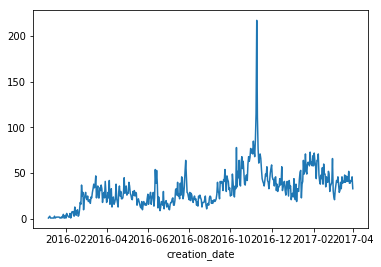

In [193]:
filtered_nlp_df[(filtered_nlp_df['subreddit']=='The_Donald') & (filtered_nlp_df['creation_date'] > dt.date(2016,1,1))].groupby('creation_date').count()['nltk_negativity'].plot.line()

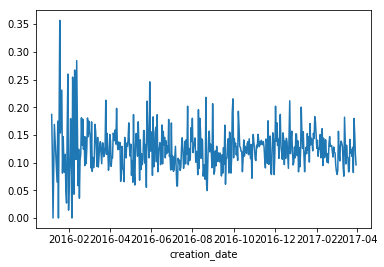

In [207]:
filtered_nlp_df[(filtered_nlp_df['subreddit']=='The_Donald') & (filtered_nlp_df['creation_date'] > dt.date(2016,1,1))].groupby('creation_date').mean()['nltk_positivity'].plot.line()

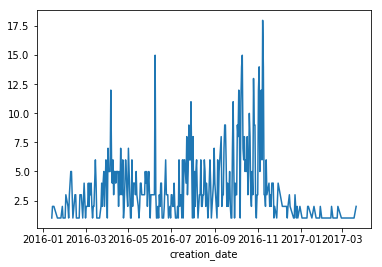

In [204]:
filtered_nlp_df[(filtered_nlp_df['subreddit']=='hillaryclinton') & (filtered_nlp_df['creation_date'] > dt.date(2016,1,1))].groupby('creation_date').count()['nltk_negativity'].plot.line()

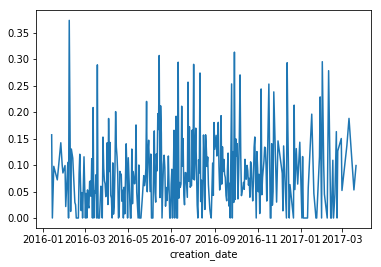

In [205]:
filtered_nlp_df[(filtered_nlp_df['subreddit']=='hillaryclinton') & (filtered_nlp_df['creation_date'] > dt.date(2016,1,1))].groupby('creation_date').mean()['nltk_negativity'].plot.line()

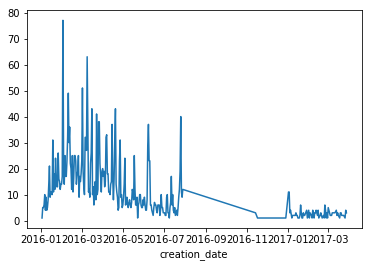

In [202]:
filtered_nlp_df[(filtered_nlp_df['subreddit']=='SandersForPresident') & (filtered_nlp_df['creation_date'] > dt.date(2016,1,1))].groupby('creation_date').count()['nltk_negativity'].plot.line()

In [184]:
filtered_nlp_df[filtered_nlp_df['creation_date'] > dt.date(2015,6,1)].groupby('creation_date').mean()['nltk_negativity'].plot.line()

,id,creation_date,body,nltk_negativity,nltk_positivity,nltk_neutrality,nb_bw_matches,subreddit,Group,Subgroup
0,cx5ynv4,2015-11-19,Boston Globe isn't known for their stellar jou...,0.091,0.000,0.909,0,2016_elections,Politics,Election
1,d9x9nl2,2016-11-12,I didn't love Hillary (like a lot of people) b...,0.073,0.243,0.684,0,2016_elections,Politics,Election
2,c50ydkn,2012-06-15,Rand Paul is unparallelled when it comes to ci...,0.000,0.000,1.000,0,watchingcongress,Politics,General Interest
3,c7rzwgp,2013-01-06,"Common, you don't expect congress to only do *...",0.247,0.000,0.753,1,watchingcongress,Politics,General Interest
4,c83c1nk,2013-01-25,Explain it like i'm 5,0.000,0.455,0.545,0,watchingcongress,Politics,General Interest
5,c50jf79,2012-06-14,Would you also consider the 2008 bailouts to b...,0.072,0.129,0.799,0,watchingcongress,Politics,General Interest
6,cf8b8xn,2014-02-06,[Most awkward member of Congress ever.](http:/...,0.242,0.000,0.758,0,watchingcongress,Politics,General Interest
7,c0vcd3n,2010-07-27,"Come on, no war! Israel and Lebanon are the t...",0.267,0.191,0.542,0,worldevents,Politics,International Politics
8,cwo22qd,2015-11-04,Everyone should watch 'The Island President' t...,0.000,0.193,0.807,0,worldevents,Politics,International Politics
9,cks5vt0,2014-09-25,There is at least one reason. Foreign interest...,0.096,0.160,0.744,0,worldevents,Politics,International Politics


In [209]:
# Load all datasets
donald = spark.read.load('../data/donald_comments.parquet')
donald.registerTempTable("donald")

In [210]:
donald.count()

16127406

In [215]:
daily_donald = spark.sql("""
    SELECT 
        created,
        COUNT(*) AS count, 
        SUM(CASE WHEN score > 0 THEN 1 ELSE 0 END) AS count_pos,
        SUM(CASE WHEN score < 0 THEN 1 ELSE 0 END) AS count_neg,
        (SUM(CASE WHEN score > 0 THEN 1 ELSE 0 END) / COUNT(*)) AS agreement_factor
    FROM donald
    GROUP BY created
""").toPandas()

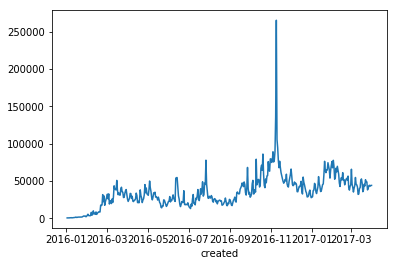

In [221]:
daily_donald[daily_donald['created']>dt.date(2016,1,1)].set_index('created')['count'].plot.line()

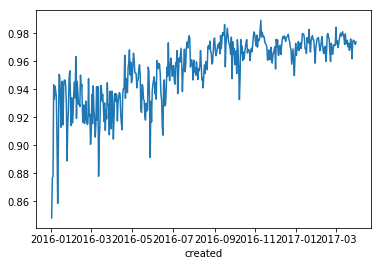

In [220]:
daily_donald[daily_donald['created']>dt.date(2016,1,1)].set_index('created')['agreement_factor'].plot.line()

In [226]:
daily_metrics['count_of_deleted_and_removed'] = daily_metrics['count_of_deleted'] + daily_metrics['count_of_removed']

In [230]:
daily_metrics['prop_of_deleted_and_removed'] = daily_metrics['count_of_deleted_and_removed'] / daily_metrics['count_of_comments']

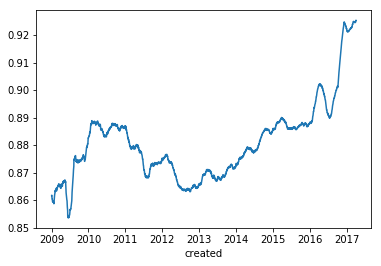

In [248]:
daily_agreement[daily_agreement.index > dt.date(2009, 1, 1)]['agreement_factor_60d_avg'].plot.line()

In [251]:
daily_agreement[daily_agreement.index > dt.date(2009, 1, 1)]['agreement_factor_60d_avg'].to_csv('daily_agreement.csv')

In [48]:
a = spark.sql("""
    SELECT *,
    AVG(controversity_score) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS controversity_score_60d_avg,
    AVG(agreement_factor) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS agreement_factor_60d_avg
    FROM (
        SELECT 
            created,
            COUNT(*) AS count,
            SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) AS count_pos,
            SUM(CASE WHEN score < 1 THEN 1 ELSE 0 END) AS count_neg,
            (SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) / COUNT(*)) AS agreement_factor,
            SUM(score) / SUM(ABS(score)) AS controversity_score
        FROM comments
        WHERE score < 1 OR score > 1
        GROUP BY created
        HAVING COUNT(*) > 5
    )
""").toPandas()

In [34]:
a = a.sort_values('created')
a = a[a['created'] > dt.date(2008, 1, 1)]
a = a.set_index('created')

In [16]:
# comments = comments.withColumn('created', func.from_unixtime(comments['created_utc'], 'yyyy-MM-dd HH:mm:ss.SS').cast(DateType()))

In [17]:
# comments.registerTempTable('comments')

In [29]:
a['agreement_factor']

created
2008-01-02            NaN
2008-01-04       9.000000
2008-01-08      14.000000
2008-01-09      12.000000
2008-01-10       7.500000
2008-01-15      15.000000
2008-01-17      20.000000
2008-01-27       6.000000
2008-01-28      14.000000
2008-01-31            NaN
2008-02-01      10.000000
2008-02-02      10.500000
2008-02-03       7.500000
2008-02-06      16.000000
2008-02-13            NaN
2008-02-21            NaN
2008-02-22      10.000000
2008-02-24      13.500000
2008-02-25       5.333333
2008-02-27       7.500000
2008-03-03      10.000000
2008-03-06      13.333333
2008-03-08      10.000000
2008-03-12      12.000000
2008-03-13            NaN
2008-03-17      10.000000
2008-03-20            NaN
2008-03-21      10.000000
2008-03-25      12.000000
2008-03-26            NaN
                 ...     
2017-03-03     881.151515
2017-03-04     790.156250
2017-03-05     814.637681
2017-03-06     862.784810
2017-03-07     993.745455
2017-03-08     968.301075
2017-03-09     994.626866
2017

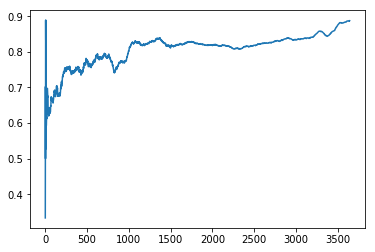

In [50]:
a['agreement_factor_60d_avg'].plot.line()

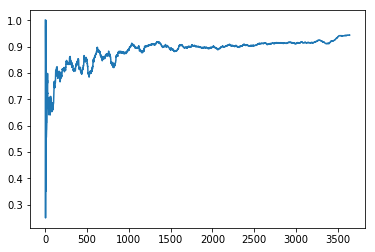

In [47]:
a['controversity_score_60d_avg'].plot.line()

In [24]:
subreddit_agreement['count'].sum()

42964916

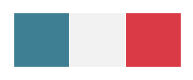

,count,count_pos,count_neg,agreement_factor
subreddit,,,,
Roadcam,31403,27401,4002,0.872560
HistoryPorn,16552,14902,1650,0.900314
FantasyPL,15920,14781,1139,0.928455
detroitlions,12176,11450,726,0.940375
bidenbro,5781,4904,877,0.848296
popheads,38938,38343,595,0.984719
Mid_Century,398,387,11,0.972362
RoomPorn,4560,4337,223,0.951096
MLS,59615,56286,3329,0.944158


In [242]:
spark.sql("""
    SELECT 
        subreddits.Group, 
        COUNT(*) as count, 
        AVG(score) as avg_score,
        STD(score) as std_score,
        STD(score) / AVG(score) as avg_std_score,
        SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) AS count_pos,
        SUM(CASE WHEN score < 1 THEN 1 ELSE 0 END) AS count_neg,
        (SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) / COUNT(*)) AS agreement_factor
    FROM comments JOIN subreddits ON LOWER(comments.subreddit) == subreddits.subreddit
    WHERE score > 5 OR score < -3
    GROUP BY subreddits.Group
""").write.mode('overwrite').parquet('agreement_per_community.parquet')

In [243]:
spark.sql("""
SELECT id, creation_date, body, nltk_negativity, nltk_positivity, nltk_neutrality, nb_bw_matches, nlp.subreddit, subreddits.Group, subreddits.Subgroup
FROM nlp JOIN subreddits 
ON LOWER(nlp.subreddit) == subreddits.subreddit
""").write.mode('overwrite').parquet('nlp_filtered_for_communities.parquet')

In [ ]:
spark.sql("""
    SELECT 
        subreddits.Group, 
        COUNT(*) as count, 
        AVG(score) as avg_score,
        STD(score) as std_score,
        STD(score) / AVG(score) as avg_std_score,
        SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) AS count_pos,
        SUM(CASE WHEN score < 1 THEN 1 ELSE 0 END) AS count_neg,
        (SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) / COUNT(*)) AS agreement_factor
    FROM comments JOIN subreddits ON LOWER(comments.subreddit) == subreddits.subreddit
    WHERE score > 5 OR score < -3
    GROUP BY subreddits.Group
""").write.mode('overwrite').parquet('agreement_per_subgroup.parquet')